## This model consists of a simple spherical and symmetric wind model with a constant wind velocity, along with a 'pseudo signal' revolving within it in a circular orbit.
## The main goal of this model is to quantify the amount of electrons along a line of sight from the orbit given an orbital phase and inclination
## Stellar parameters are modelled after the star SS 2883 of the HMXB system PSR B1259-63. Wind terminal velocity is taken from the paper - https://arxiv.org/pdf/0806.4868, while the remaining stellar properties are taken from https://arxiv.org/abs/astro-ph/0501660.

# Equations and Geometry
## Electron number density
# $n_{e}(r) = \frac{\rho}{\mu_{e}m_{p}} = \frac{\dot{M}}{4\pi\mu_{e}m_{p}r^2v_{\infty}} = \frac{k}{r^2}$
Where
# $\rho = \frac{\dot{M}}{4\pi r^2v_{\infty}}$
And
# $k = \frac{\dot{M}}{4\pi\mu_{e}m_{p}v_{\infty}}$
With
* $\rho$ =      Density
* $\mu_{e}$ =   Mean molecular weight per free electron (typically set at a value of 1.2)
* $m_{p}$ =     Proton mass
* $\dot{M}$ =   Wind mass loss
* $v_{\infty}$ = Wind terminal velocity
* $r$ =         radial distance from the center of the star

By placing the star at the xy plane origin, for an orbit radius $a$, the signal position in polar coordinates is defined as $r_s = a(cos(\phi),sin(\phi),0)$, where $\phi$ is the orbital phase. The observer unit vector (dircetion of signal to observer) is then defined as $\hat{n} = (sin(i), 0, cos(i))$, where $i$ is the inclination. The radial distance of the signal from the star along the path of the line of sight become $r(s) = r_s + s\hat{n}$, where $s\ge0$, is the distance along the line of sight. 

The number density at a specific point along the orbit can then be described as
# $n_e(r(s)) = \frac{k}{r(s)^2}$

From the definition of $r(s)$, 

# $r(s)^2 = (r_s + s\hat{n})^2 = a^2 + 2as cos(\phi) sin (i) + s^2$

## Dispersion Measure
# $DM(\phi,i) = \int_{0}^{\infty}n_e(|r(s)|)ds = k\int_{0}^{\infty}\frac{ds}{|r(s)|^2}$

let $A = a cos(\phi) sin (i)$, and $B = \sqrt{a^2 - A^2} = a\sqrt{1 - cos^2 (\phi) sin^2 (i)}$, the dispersion measure becomes
# $DM(\phi,i) = \frac{k}{B}[\frac{\pi}{2} - arctan(\frac{A}{B})]$

In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as con

In [2]:
#Number density function
def num_density(phi, i, a_Rsun, Mdot_Msun_per_yr, v_inf_kms, s, mu_e=1.2):
    '''This function calculates the number density at a specific point along a circular orbit within a spherically cymmetric wind 
    with constant velocity.
    -----------------------------------------------------------------------------------------------------------------------------
    parameters:
    
    phi              [float] -> Orbital phase (rad)
    i                [float] -> Inclination (rad)
    a_Rsun           [float] -> Orbital radius (solar radii)
    Mdot_Msun_per_yr [float] -> Wind mass loss (solar masses per year)
    v_inf_kms        [float] -> Terminal velocity of wind (km/s)
    mu_e             [float] -> Mean molecular weight per free electron
    s                [float] -> Distance along line of sight from signal (AU)
    
    -----------------------------------------------------------------------------------------------------------------------------
    Returns:
    
    The function returns the number density [float] -> (cm^-3)'''
    a = (a_Rsun * con.R_sun).cgs .value                          #Converts the orbital radius from solar radii to cm
    Mdot = (Mdot_Msun_per_yr * con.M_sun / (1 * u.yr)).cgs.value #Converts the stellar mass loss from solar mass per year to g/s
    v_inf = (v_inf_kms * u.km / u.s).cgs.value                   #Converts the wind velocity from km/s to cm/s
    k = Mdot / (4*np.pi*mu_e*con.m_p*v_inf)                      #Calculates the k constant (cm^-1)
    r_s_sqrd = a**2 + 2*a*s*np.cos(phi)*np.sin(i) + s**2         #Calculates the squared radial distance from the star along the line of sight
    return k/r_s_sqrd  

In [3]:
#DM function
def dm_constant_wind(phi, i, a_Rsun, Mdot_Msun_per_yr, v_inf_kms, mu_e=1.2):
    '''This function calculates the dispersion measure along a line of sight, given orbital phase and inclination, 
    assuming a spherically symmetric wind with constant velocity.
    --------------------------------------------------------------------------------------------------------------
    Parameters:
    
    phi              [float] -> Orbital phase (rad)
    i                [float] -> Inclination (rad)
    a_Rsun           [float] -> Orbital radius (solar radii)
    Mdot_Msun_per_yr [float] -> Wind mass loss (solar masses per year)
    v_inf_kms        [float] -> Terminal velocity of wind (km/s)
    mu_e             [float] -> Mean molecular weight per free electron
    
    --------------------------------------------------------------------------------------------------------------
    Returns:
    
    The function returns the dispersion measure [float] -> (pc cm^-3).'''
    a = (a_Rsun * con.R_sun).cgs.value                            #Converts the orbital radius from solar radii to cm
    Mdot = (Mdot_Msun_per_yr * con.M_sun / (1 * u.yr)).cgs.value  #Converts the stellar mass loss from solar mass per year to g/s
    v_inf = (v_inf_kms * u.km / u.s).cgs.value                    #Converts the wind velocity from km/s to cm/s
    k = Mdot / (4*np.pi*mu_e*con.m_p*v_inf)                       #Calculates the k constant (cm^-1)
    A = a*np.cos(phi)*np.sin(i)                                   #Calculates the A value (cm)
    B = a*np.sqrt(1 - (np.cos(phi)*np.sin(i))**2)                 #Calculates the B value (cm)
    
    #Since edge-on inclination (pi/2) results in B=0, it is replaced by a small value at this limit to avoid division by 0
    sv = 1e-12*a
    B = np.maximum(B, sv)                            #Takes the maximum non-zero value
    return (k/B) * (np.pi/2 - np.arctan2(A, B))/u.pc #Dividing by PC to convert to units of pc cm^-3

In [4]:
#Calculating the number density along the line of sight
i_deg = [36, 90, 145, 250]                                                             #Inclinations in degrees
i = np.deg2rad(i_deg)                                                                  #Converting the inclinations to rad
phi_deg = [0, 100, 165, 320]                                                           #Orbital phases in degrees
phi = np.deg2rad(phi_deg)                                                              #Converting the orbital phases to rad
s = np.logspace(np.log10(1e11), np.log10((100 * con.au).value), 512)                   #Line of sight distance array
n_e1 = num_density(phi[0], i[0], a_Rsun=6, Mdot_Msun_per_yr=1e-6, v_inf_kms=1350, s=s) #Number densities
n_e2 = num_density(phi[1], i[1], a_Rsun=6, Mdot_Msun_per_yr=1e-6, v_inf_kms=1350, s=s)
n_e3 = num_density(phi[2], i[2], a_Rsun=6, Mdot_Msun_per_yr=1e-6, v_inf_kms=1350, s=s)
n_e4 = num_density(phi[3], i[3], a_Rsun=6, Mdot_Msun_per_yr=1e-6, v_inf_kms=1350, s=s)

In [5]:
#print(s)
#print(n_e)

When plotting the number density as a function of line of sight distance, it is important to revisit the squared radial distance from the star along the line of sight:
# $r(s)^2 = (r_s + s\hat{n})^2 = a^2 + 2as cos(\phi) sin (i) + s^2$
As we can see, when
## $a >> s$, $r(s)^2 \approx a^2$
so
## $n_e(r(s)) \approx \frac{k}{a^2} = const$
Therefore, we can only start seeing a power law relation when 
## $a \sim s$

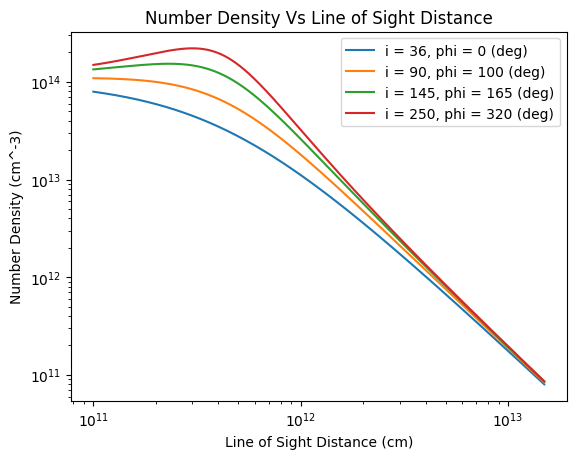

In [6]:
#Plotting the number density as a function of line of sight distance
plt.plot(s, n_e1, label = 'i = ' + str(i_deg[0]) + ', phi = ' + str(phi_deg[0]) + ' (deg)')
plt.plot(s, n_e2, label = 'i = ' + str(i_deg[1]) + ', phi = ' + str(phi_deg[1]) + ' (deg)')
plt.plot(s, n_e3, label = 'i = ' + str(i_deg[2]) + ', phi = ' + str(phi_deg[2]) + ' (deg)')
plt.plot(s, n_e4, label = 'i = ' + str(i_deg[3]) + ', phi = ' + str(phi_deg[3]) + ' (deg)')
plt.title('Number Density Vs Line of Sight Distance')
plt.xlabel('Line of Sight Distance (cm)')
plt.ylabel('Number Density (cm^-3)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [7]:
#Calculating the DM
i_deg = 36                                                                     #Inclination in degrees
i = np.deg2rad(i_deg)                                                          #Converting the inclination to rad
phi = np.linspace(0, 2*np.pi, 512, endpoint=False)                             #Orbital phase array in rad (redundancy removed)
DM = dm_constant_wind(phi, i, a_Rsun=6, Mdot_Msun_per_yr=1e-6, v_inf_kms=1350) #Dispersion measure

In [8]:
#print(phi)
#print(DM)

Text(0, 0.5, 'Dispersion Measure (pc cm^-3)')

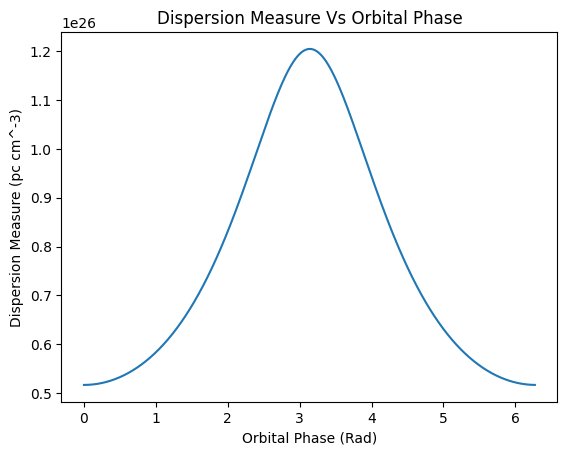

In [9]:
#Plotting the DM as a function of the orbital phase
plt.plot(phi, DM)
plt.title('Dispersion Measure Vs Orbital Phase')
plt.xlabel('Orbital Phase (Rad)')
plt.ylabel('Dispersion Measure (pc cm^-3)')